In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Machine Predictive Maintenance Classification Dataset
Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

The dataset consists of 10 000 data points stored as rows with 14 features in columns

 * __UID:__ unique identifier ranging from 1 to 10000
 * __productID:__ consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
 * __air temperature [K]:__ generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
 * __process temperature [K]:__ generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
 * __rotational speed [rpm]:__ calculated from power of 2860 W, overlaid with a normally distributed noise
 * __torque [Nm]:__ torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
 * __tool wear [min]:__ The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
 * __'machine failure'__ label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

In [2]:
df = pd.read_csv('data/predictive_maintenance.csv')

In [3]:
df.head()

,udi,product_id,type,air_temp,process_temp,rotational_speed,torque,tool_wear,target,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
print(df.dtypes)

udi                   int64
product_id           object
type                 object
air_temp            float64
process_temp        float64
rotational_speed      int64
torque              float64
tool_wear             int64
target                int64
failure_type         object
dtype: object


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   udi               10000 non-null  int64  
 1   product_id        10000 non-null  object 
 2   type              10000 non-null  object 
 3   air_temp          10000 non-null  float64
 4   process_temp      10000 non-null  float64
 5   rotational_speed  10000 non-null  int64  
 6   torque            10000 non-null  float64
 7   tool_wear         10000 non-null  int64  
 8   target            10000 non-null  int64  
 9   failure_type      10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None


In [5]:
df.shape

(10000, 10)

In [6]:
df.isna().sum()

udi                 0
product_id          0
type                0
air_temp            0
process_temp        0
rotational_speed    0
torque              0
tool_wear           0
target              0
failure_type        0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [9]:
df.nunique()

udi                 10000
product_id          10000
type                    3
air_temp               93
process_temp           82
rotational_speed      941
torque                577
tool_wear             246
target                  2
failure_type            6
dtype: int64

In [10]:
df.describe()

,udi,air_temp,process_temp,rotational_speed,torque,tool_wear,target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


### Define Feature Data Types

In [13]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 7 numerical features : ['udi', 'air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear', 'target']

We have 3 categorical features : ['product_id', 'type', 'failure_type']


In [14]:
print("Categories in 'failure_type' variable:     ",end=" " )
print(df['failure_type'].unique())

Categories in 'failure_type' variable:      ['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']


In [15]:
df['failure_type'].value_counts()

failure_type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [33]:
def round_mean(x, decimals):
    return round(x.mean(), decimals)

# df.groupby('product_id').agg(
#     avg_failure_rate = ('target','mean')
# )

product_agg_results = df.groupby('product_id').agg(
    avg_failure_rate = ('target',lambda x: round_mean(x, 3)),
    product_count = ('product_id', 'count')
)

product_agg_results.sort_values(by='avg_failure_rate', ascending=False, inplace=True)
product_agg_results = product_agg_results[product_agg_results['product_count'] >= 3]

product_agg_results.head()

,avg_failure_rate,product_count
product_id,,


# Correlation Analysis and Feature Selection

In [20]:
# Summary of input and target variables
input_vars = ['type', 'air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear']
binary_target = 'target'
multiclass_target = 'failure_type'

### Define Statistical Tests and Data Visualization Functions
 * Mann-Whitney U Test: Test continuous inputs vs binary 'target' variable
 * Kruskal-Wallis: Test continuous input vs multi-categorical 'failure_type'
 * Chi-Squared Test: Test categorical inputs vs both targets; 'target' and 'failure_type'
 * Visualizations: Leverage Seaborn package to visualize distributions for categorical and numeric input features against our two potential target variables; 'target' and 'failure_type'

In [18]:
# Function: Mann-Whitney U Test
def mann_whitney_test(df, var, target):
    group1 = df[df[target]==0][var]
    group2 = df[df[target]==1][var]
    stat, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    return stat, p

# Function: Kruskal-Wallis Test
def kruskal_test(df, var, target):
    groups = [df[df[target]==label][var] for label in df[target].unique()]
    stat, p = stats.kruskal(*groups)
    return stat, p

# Function: Chi-Square Test
def chi_square_test(df, cat_var, target):
    contingency = pd.crosstab(df[cat_var], df[target])
    stat, p, dof, expected = stats.chi2_contingency(contingency)
    return stat, p

=== Binary Target Analysis: 'target' ===
Chi-Square Test for type vs target: p=0.0010


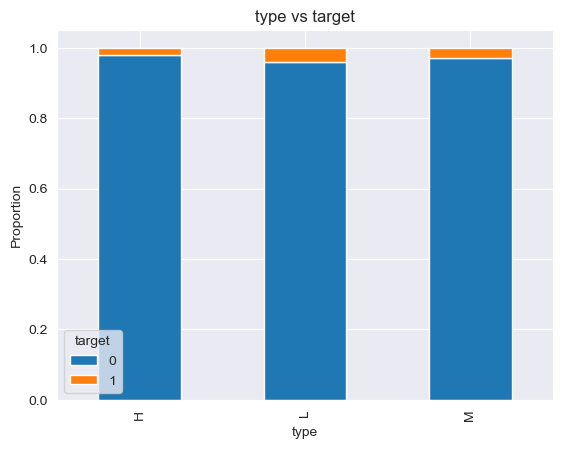

Mann-Whitney U Test for air_temp vs target: p=0.0000


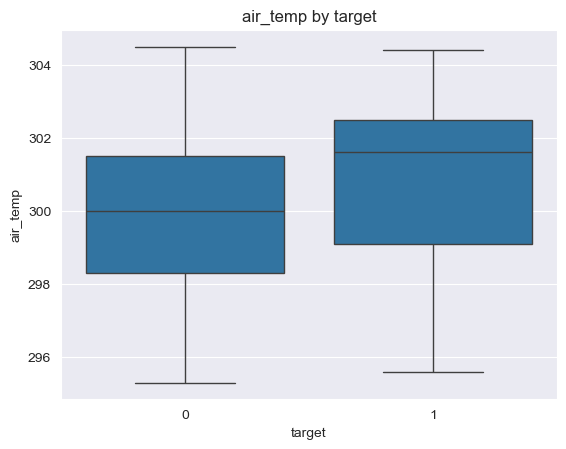

Mann-Whitney U Test for process_temp vs target: p=0.0001


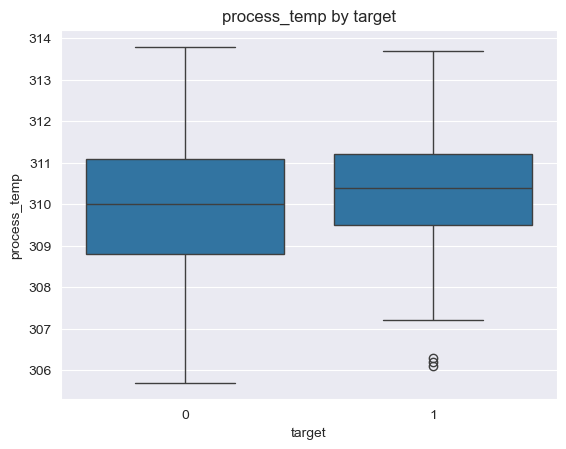

Mann-Whitney U Test for rotational_speed vs target: p=0.0000


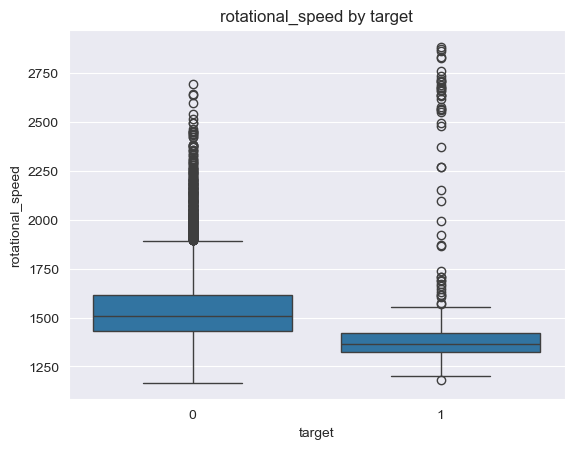

Mann-Whitney U Test for torque vs target: p=0.0000


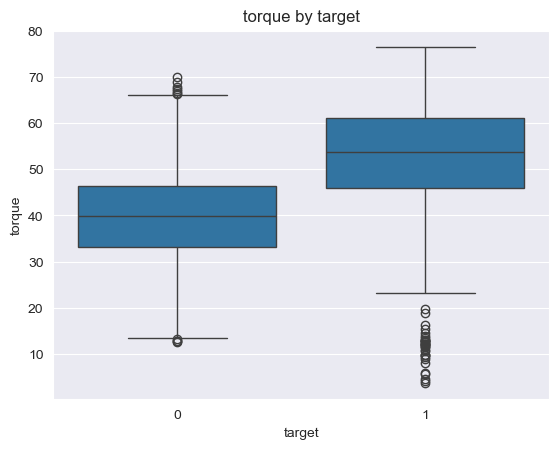

Mann-Whitney U Test for tool_wear vs target: p=0.0000


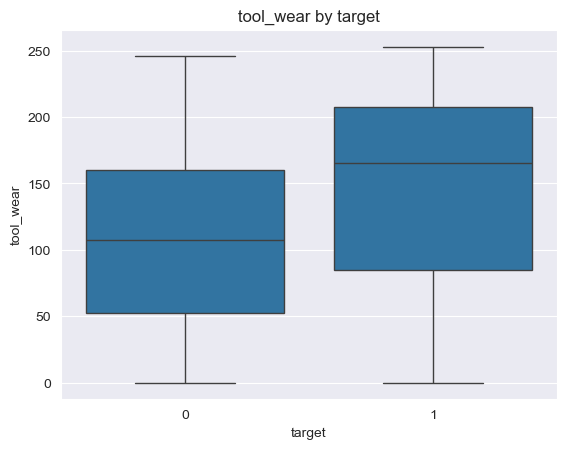

In [21]:
print("=== Binary Target Analysis: 'target' ===")
for var in input_vars:
    if df[var].dtype == 'O':
        stat, p = chi_square_test(df, var, binary_target)
        print(f"Chi-Square Test for {var} vs {binary_target}: p={p:.4f}")

        # Visualization
        cross_tab = pd.crosstab(df[var], df[binary_target], normalize='index')
        cross_tab.plot(kind='bar', stacked=True)
        plt.title(f"{var} vs {binary_target}")
        plt.ylabel("Proportion")
        plt.show()

    else:
        stat, p = mann_whitney_test(df, var, binary_target)
        print(f"Mann-Whitney U Test for {var} vs {binary_target}: p={p:.4f}")

        # Visualization
        sns.boxplot(x=binary_target, y=var, data=df)
        plt.title(f"{var} by {binary_target}")
        plt.show()


=== Multiclass Target Analysis: 'failure_type' ===
Chi-Square Test for type vs failure_type: p=0.0000


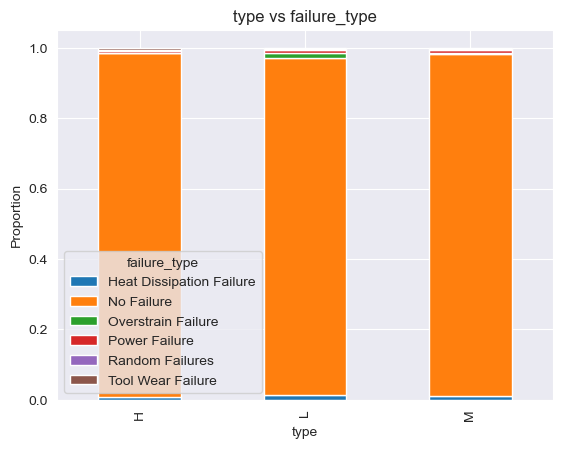

Kruskal-Wallis Test for air_temp vs failure_type: p=0.0000


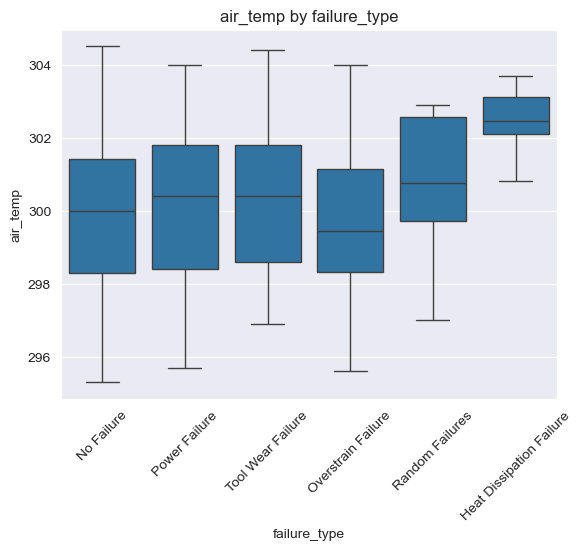

Kruskal-Wallis Test for process_temp vs failure_type: p=0.0000


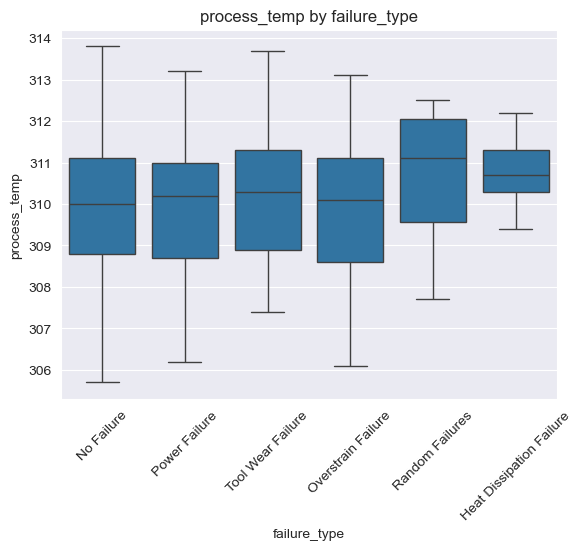

Kruskal-Wallis Test for rotational_speed vs failure_type: p=0.0000


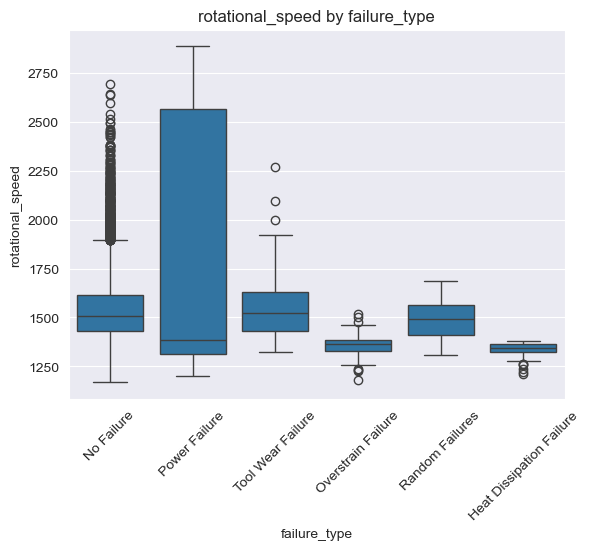

Kruskal-Wallis Test for torque vs failure_type: p=0.0000


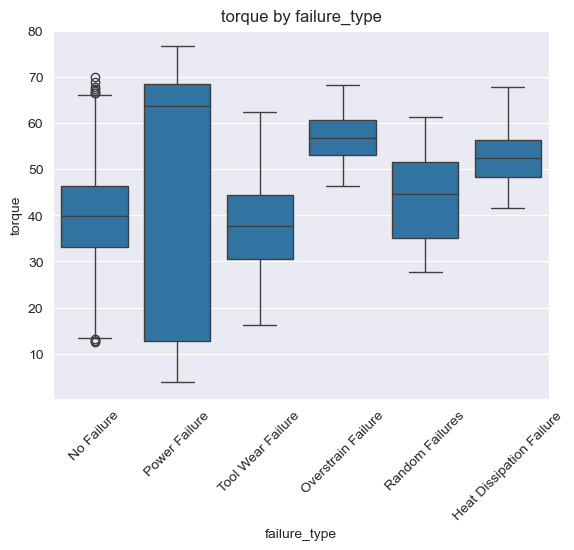

Kruskal-Wallis Test for tool_wear vs failure_type: p=0.0000


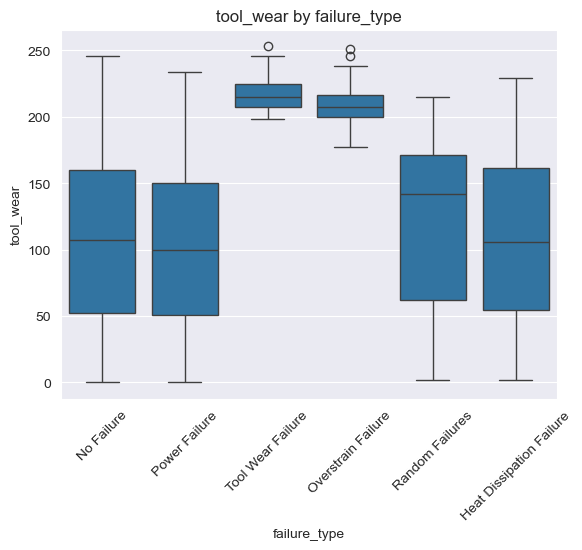

In [22]:
print("\n=== Multiclass Target Analysis: 'failure_type' ===")
for var in input_vars:
    if df[var].dtype == 'O':
        stat, p = chi_square_test(df, var, multiclass_target)
        print(f"Chi-Square Test for {var} vs {multiclass_target}: p={p:.4f}")

        # Visualization
        cross_tab = pd.crosstab(df[var], df[multiclass_target], normalize='index')
        cross_tab.plot(kind='bar', stacked=True)
        plt.title(f"{var} vs {multiclass_target}")
        plt.ylabel("Proportion")
        plt.show()

    else:
        stat, p = kruskal_test(df, var, multiclass_target)
        print(f"Kruskal-Wallis Test for {var} vs {multiclass_target}: p={p:.4f}")

        # Visualization
        sns.boxplot(x=multiclass_target, y=var, data=df)
        plt.title(f"{var} by {multiclass_target}")
        plt.xticks(rotation=45)
        plt.show()